In [7]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from datetime import datetime

!pip install praat-parselmouth
import parselmouth
from parselmouth.praat import call

import os
from glob import glob
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


When prompted to obtain the access code, make sure to use the google drive containing the speech database.

Change the address here to the location of your speech database on google drive. For Databases that are not the JLCorpus, make sure to adjust relevant data when running the code. 

In [8]:
!unzip "/content/drive/Shared drives/Project 115/Data/JLCorpus_P115.zip"

Archive:  /content/drive/Shared drives/Project 115/Data/JLCorpus_P115.zip
  inflating: JLCorpus_P115/female1_angry_10a_1.wav  
  inflating: JLCorpus_P115/female1_angry_10a_2.wav  
  inflating: JLCorpus_P115/female1_angry_10b_1.wav  
  inflating: JLCorpus_P115/female1_angry_10b_2.wav  
  inflating: JLCorpus_P115/female1_angry_11a_1.wav  
  inflating: JLCorpus_P115/female1_angry_11a_2.wav  
  inflating: JLCorpus_P115/female1_angry_11b_1.wav  
  inflating: JLCorpus_P115/female1_angry_11b_2.wav  
  inflating: JLCorpus_P115/female1_angry_12a_1.wav  
  inflating: JLCorpus_P115/female1_angry_12a_2.wav  
  inflating: JLCorpus_P115/female1_angry_12b_1.wav  
  inflating: JLCorpus_P115/female1_angry_12b_2.wav  
  inflating: JLCorpus_P115/female1_angry_13a_1.wav  
  inflating: JLCorpus_P115/female1_angry_13a_2.wav  
  inflating: JLCorpus_P115/female1_angry_13b_1.wav  
  inflating: JLCorpus_P115/female1_angry_13b_2.wav  
  inflating: JLCorpus_P115/female1_angry_14a_1.wav  
  inflating: JLCorpus_P11

In [9]:
filelist = os.listdir("/content/JLCorpus_P115") 

In [10]:
observed_p_emotions=['angry', 'excited', 'happy', 'neutral', 'sad']
observed_s_emotions=['anxious', 'apologetic', 'confident', 'enthusiastic', 'worried']
observed_f_emotions=['angry', 'anxious','apologetic',  'confident', 'enthusiastic','excited', 'happy', 'neutral', 'sad', 'worried']
the_emotion = observed_f_emotions

In [11]:
#read them into pandas
data = pd.DataFrame(filelist)

# Renaming the column name to file
data = data.rename(columns={0:'file'})

# We create an empty list where we will append all the speakers ids for each row of our dataframe by slicing the file name since we know the id is the first number before the hash
emotion = []
num = []
for i in range(0, len(data)):
    emotion.append(data['file'][i].split('_')[1])
    if not data['file'][i].endswith(".wav"):
        num.append(i)

# We now assign the speaker to a new column 
data['emotion'] = emotion

data = data.drop(data.index[num])

data = data[data['emotion'].isin(the_emotion)]
data = data.reset_index(drop=True)
display(data)

,file,emotion
0,male2_confident_11a_1.wav,confident
1,male1_neutral_4a_2.wav,neutral
2,female2_anxious_7a_2.wav,anxious
3,female1_angry_2b_2.wav,angry
4,male1_apologetic_2a_2.wav,apologetic
...,...,...
2395,male2_anxious_8b_2.wav,anxious
2396,female2_anxious_1a_2.wav,anxious
2397,male1_happy_2b_1.wav,happy
2398,female1_neutral_6a_1.wav,neutral


## **FEATURE EXTRACTION**

---
This section details the feature extraction of 11 features. 
The extract_feature() funtion extracts spectral features using the Librosa 


*   The extract_feature() funtion extracts spectral features using the Librosa library. 
*   The measurePitch() function extracts voice quality and prosody features using the parselmouth Library to interface with praat.




In [12]:
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('/content/JLCorpus_P115')+'/'+ files.file.split(".wav")[0]+'.wav')

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    # We add also the classes of each file as a label at the end
    label = files.emotion

    pm = measurePitch(parselmouth.Sound(file_name), 75, 500, "Hertz")

    return mfccs, chroma, mel, contrast, tonnetz, pm, label

In [13]:
def measurePitch(snd, f0min, f0max, unit):
    pitch = snd.to_pitch()
    pmArray =np.array([])
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(snd, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([snd, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([snd, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([snd, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([snd, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([snd, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([snd, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    intensity = snd.to_intensity()
    meanIntense = parselmouth.praat.call(intensity, "Get mean", snd.xmin, snd.xmax)
    Ltas = call(snd, "To Ltas", f0max-f0min)
    number =  parselmouth.praat.call(Ltas, "Get number of bins")
    beta = parselmouth.praat.call(Ltas, "Get value in bin", 43)/parselmouth.praat.call(Ltas, "Get value in bin", 1)
    meanLtas = parselmouth.praat.call(Ltas, "Get mean", f0min, f0max, "energy")
    pmArray = np.hstack((meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer, meanIntense, meanLtas))
    return pmArray

In [14]:
startTime = datetime.now()

In [15]:
features_labels = data.apply(extract_features, axis=1)

In [16]:
print(datetime.now() - startTime)

0:52:52.910391


In [17]:
features_df = pd.DataFrame(features_labels)
if (the_emotion == observed_p_emotions):
  features_df.to_csv('primary_features_df_librosa_praat.csv', index=False)
elif (the_emotion == observed_s_emotions):
  features_df.to_csv('secondary_features_df_librosa_praat.csv', index=False)
elif (the_emotion == observed_f_emotions):
  features_df.to_csv('all_features_df_librosa_praat.csv', index=False)

In [18]:
features = []
for i in range(0, len(features_labels)):
    features.append(np.concatenate((features_labels[i][0], features_labels[i][1], 
                features_labels[i][2], features_labels[i][3],
                features_labels[i][4], features_labels[i][5]), axis=0))

In [19]:
labels = []
for i in range(0, len(features_labels)):
    labels.append(features_labels[i][6])

In [20]:
np.unique(labels, return_counts=True)

(array(['angry', 'anxious', 'apologetic', 'confident', 'enthusiastic',
        'excited', 'happy', 'neutral', 'sad', 'worried'], dtype='<U12'),
 array([240, 240, 240, 240, 240, 240, 240, 240, 240, 240]))

In [21]:
X = np.array(features)

In [22]:
y = np.array(labels)

In [23]:
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [24]:
X.shape
y.shape
print(X)
print(X.shape)

[[-4.38239009e+02  1.27749331e+02  1.18111117e+01 ...  9.73895514e-02
   5.28803041e+01  3.34566538e+01]
 [-4.82871842e+02  9.44347762e+01  4.64236577e+00 ...  1.34329636e-01
   4.96586592e+01  2.78507945e+01]
 [-5.37145788e+02  6.94086414e+01  5.97502806e-01 ...  6.06437057e-02
   4.36857414e+01  2.12528891e+01]
 ...
 [-4.58952536e+02  1.17332261e+02  1.04018961e+01 ...  9.70262990e-02
   4.98866728e+01  3.00952917e+01]
 [-5.31632492e+02  6.49330305e+01  1.49369261e+00 ...  6.10721241e-02
   4.20237065e+01  2.10447799e+01]
 [-5.53650713e+02  8.38309072e+01  1.40894237e+00 ...  9.64033512e-02
   4.12825553e+01  1.78323948e+01]]
(2400, 209)


In [25]:
X_train = np.concatenate((X[0::4], X[1::4]), axis = 0)
y_train = np.concatenate((y[0::4] , y[1::4]), axis = 0)

X_val = X[2::4]
y_val = y[2::4]

X_test = X[3::4]
y_test = y[3::4]

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


(1200, 209)
(1200, 10)
(600, 209)
(600, 10)


In [27]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)


## **MACHINE LEARNING**


---
This is the composition of the keras model. The model runs for 200 epochs with dropouts implemented in each layer.


In [28]:
model = Sequential()

model.add(Dense(209, input_shape=(209,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(len(the_emotion), activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [29]:
startTime = datetime.now()

In [30]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/200
5/5 [==============================] - 0s 43ms/step - loss: 2.4244 - accuracy: 0.1450 - val_loss: 2.0305 - val_accuracy: 0.2433
Epoch 2/200
5/5 [==============================] - 0s 10ms/step - loss: 2.1010 - accuracy: 0.2225 - val_loss: 1.8745 - val_accuracy: 0.3017
Epoch 3/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9792 - accuracy: 0.2725 - val_loss: 1.7681 - val_accuracy: 0.3533
Epoch 4/200
5/5 [==============================] - 0s 13ms/step - loss: 1.8414 - accuracy: 0.3325 - val_loss: 1.6656 - val_accuracy: 0.4000
Epoch 5/200
5/5 [==============================] - 0s 10ms/step - loss: 1.7488 - accuracy: 0.3467 - val_loss: 1.5651 - val_accuracy: 0.4400
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6422 - accuracy: 0.4042 - val_loss: 1.4737 - val_accuracy: 0.4450
Epoch 7/200
5/5 [==============================] - 0s 10ms/step - loss: 1.5538 - accuracy: 0.4108 - val_loss: 1.3938 - val_accuracy: 0.4800
Epoch 8/200
5/5 [===

In [31]:
print(datetime.now() - startTime)

0:00:10.349830


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 209)               43890     
_________________________________________________________________
dropout (Dropout)            (None, 209)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               26880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1

## **RESULTS**


---
These are the results of the model with the 25% testing split. Includes accuracy per epoch aswell as loss curve and confusion matrix


In [33]:
def printInput(fileName):
    theRow = test.loc[test['file'] == fileName]

    print("File Name:  ", theRow.file.item())
    print("Emotion:    ", theRow.emotion.item())
 

In [34]:
def predict(fileName):
    theRow = test.loc[test['file'] == fileName]

    print("File Name:  ", theRow.file.item())
    print("Prediction: ", theRow.predictions.item())

In [35]:
preds = model.predict_classes(X_test)
test = data[3::4]

the_emotion_dict = {i: the_emotion[i] for i in range(len(the_emotion))}

emotion_preds = []
for i in range(len(preds)):
  emotion_preds.append(the_emotion_dict[preds[i]])

test['predictions'] = emotion_preds


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [36]:
print(round(len(test[test['emotion'] == test['predictions']])/len(test),2)*100, "%")

80.0 %


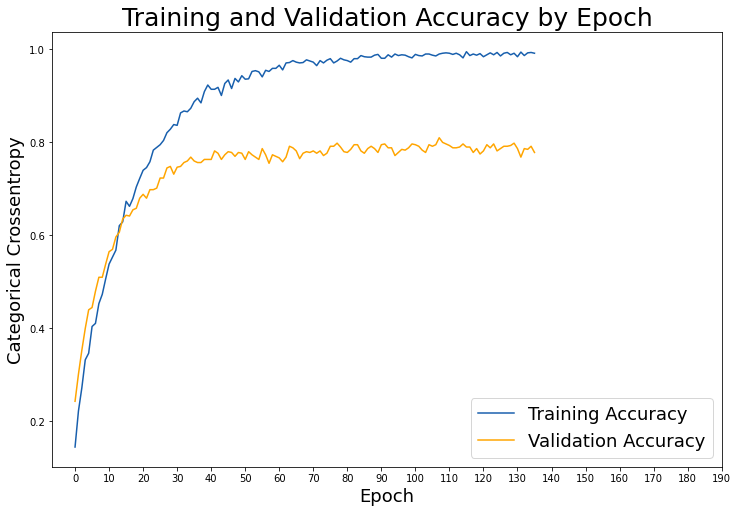

In [37]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,200,10), range(0,200,10))

plt.legend(fontsize = 18);

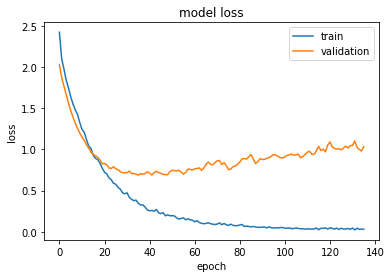

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [39]:
cm = confusion_matrix(test['emotion'], test['predictions'])
df = pd.DataFrame(np.array(cm),
                   columns=the_emotion,
                   index = the_emotion)
df.style

def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: salmon')
    return pd.DataFrame(a, index=df.index, columns=df.columns)


s = df.style.apply(highlight_diag, axis=None)


cm = sns.light_palette("salmon", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
display(s)

,angry,anxious,apologetic,confident,enthusiastic,excited,happy,neutral,sad,worried
angry,57,3,0,0,2,7,0,1,0,0
anxious,0,42,0,0,4,0,0,0,0,5
apologetic,0,0,48,4,0,0,0,1,7,3
confident,0,5,1,46,3,0,1,1,1,3
enthusiastic,1,4,0,2,36,0,3,0,0,0
excited,12,0,0,0,0,51,0,0,0,0
happy,0,2,0,1,8,0,44,2,1,1
neutral,0,0,1,1,0,0,0,55,4,1
sad,0,0,5,0,0,0,0,0,50,3
worried,0,2,4,0,3,1,0,1,3,53


## **TESTING**


---

This section will allow you to pass in any file in the JLCorpus database and test it against the model to determine if it can correctly catagorise it. 


In [40]:
fileName = "female2_worried_5b_1.wav"
fileName = "male2_excited_5a_2.wav"

In [41]:
printInput(fileName)

File Name:   male2_excited_5a_2.wav
Emotion:     excited


In [42]:
predict(fileName)

File Name:   male2_excited_5a_2.wav
Prediction:  excited
